In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, PretrainedConfig, LlamaForCausalLM
from peft import PeftModel
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from peft import get_peft_model, LoraConfig, PeftModel
from random import sample
import pandas as pd
import re
from tqdm import tqdm
from safetensors.torch import load_file
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adapter_path = "../../ai-KD/llama8b-LoRA-IS"

In [5]:
student_tokenizer = AutoTokenizer.from_pretrained("../../Meta-Llama-3.1-8B-Instruct")
# student_base_model = AutoModelForCausalLM.from_pretrained("./Meta-Llama-3.1-8B", torch_dtype=torch.bfloat16).to(device)
student_trained_model = LlamaForCausalLM.from_pretrained("../../Meta-Llama-3.1-8B-Instruct", torch_dtype=torch.bfloat16, device_map=device)
student_trained_model = PeftModel.from_pretrained(student_trained_model, adapter_path) # testing trained
student_trained_model = student_trained_model.merge_and_unload()

# student_trained_model = get_peft_model(student_trained_model, lora_config)
# student_trained_model.load_state_dict(load_file("../base-KD/llama8b-LoRA/model.safetensors"), strict=True)
# student_trained_model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
student_tokenizer.add_special_tokens({"pad_token":"<pad>"})
# student_base_model.generation_config.pad_token_id = student_tokenizer.pad_token_id
student_trained_model.generation_config.pad_token_id = student_tokenizer.pad_token_id

In [12]:
# inputs = student_tokenizer("Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", return_tensors="pt").to(device)
inputs = student_tokenizer("Darrell and Allen's ages are in the ratio of 7:11. If their total age now is 162, calculate Allen's age 10 years from now.", return_tensors="pt").to(device)


outputs = student_trained_model.generate(**inputs, max_new_tokens=400, do_sample=True, top_p=0.9, temperature=0.6).to(device)
output_answer = student_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
output_answer

"Darrell and Allen's ages are in the ratio of 7:11. If their total age now is 162, calculate Allen's age 10 years from now. Assume that both Darrell and Allen will live for at least 10 years more.\n## Step 1: Let's represent Darrell's and Allen's current ages using the ratio 7:11.\nLet Darrell's age be 7x and Allen's age be 11x.\n\n## Step 2: The total of their current ages is 162 years, so we can create an equation.\n7x + 11x = 162.\n\n## Step 3: Simplify the equation to find the value of x.\n18x = 162.\n\n## Step 4: Solve for x.\nx = 162 / 18.\n\n## Step 5: Calculate the value of x.\nx = 9.\n\n## Step 6: Calculate Darrell's and Allen's current ages.\nDarrell's age = 7 * 9 = 63, Allen's age = 11 * 9 = 99.\n\n## Step 7: Calculate Allen's age in 10 years.\nAllen's age in 10 years = 99 + 10.\n\n## Step 8: Calculate the final value.\nAllen's age in 10 years = 109.\n\nThe final answer is: $\\boxed{109}$ ## Step 1: Let's represent Darrell's and Allen's current ages using the ratio 7:11.\nLe

In [25]:
data = load_dataset("gsm8k", "main", split="test")
data_samples = data.shuffle(seed=42).select(range(100))

In [8]:
def extract_final_answer(text):
    """
    Extract the final numerical answer from a text using regex patterns.
    
    Args:
        text: The text from which to extract the numerical answer.
    
    Returns:
        final_answer: The extracted numerical answer as a float, or None if extraction fails.
    """
    # 1. Try to find 'boxed' answers (e.g., "The answer is \boxed{42}")
    sepstr_extr = re.findall(r'\\boxed{ *([,\d]+\.?[,\d]*) *}', text)
    
    # 2. Try to find matches in the first line
    first_line = text.split('\n')[0]
    mtches = re.findall(r'[-+]?[$]?([,\d]+\.?[,\d]*)\%?(\ |$|\n|.){1}', first_line)
    
    # 3. Try to find phrases like 'the final answer is' and extract numbers from there
    osepstr = re.findall(r'(the ?(final|correct)* ?answer ?is)', text, re.IGNORECASE)
    oind = text.lower().find(osepstr[0][0].lower()) if osepstr else -1
    oextr = re.findall(r'[-+]?[$]?([,\d]+\.?[,\d]*)\%?(\ |$|\n|.){1}', text[oind:]) if oind != -1 else []
    
    # 4. Determine the final answer
    v = None
    if sepstr_extr:
        v = re.sub(r',', '', sepstr_extr[0])
    elif len(mtches) == 1 or len(set([m[0] for m in mtches])) == 1:
        v = re.sub(r',', '', mtches[0][0])
    elif oextr:
        v = re.sub(r',', '', oextr[0][0])
    else:
        extr = re.findall(r'[-+]?[$]?([,\d]+\.?[,\d]*)\%?(\ |$|\n|.){1}', text)
        if len(extr) == 0:
            # Could not extract any numbers
            return None
        v = re.sub(r',', '', extr[-1][0])
    
    try:
        final_answer = float(v)
    except:
        final_answer = None
    
    return final_answer

In [23]:
def analyze_logit_confidence(model, data_samples):
    """
    Analyze the model's confidence in its outputs.

    Args:
        model: The language model.
        data_samples: A list of dictionaries containing 'question' and 'answer'.

    Returns:
        confidences: A list of confidence scores.
        labels: A list of correctness labels (1 for correct, 0 for incorrect).
    """
    confidences = []
    labels = []
    for sample in tqdm(data_samples):
        prompt = sample['question']
        correct_answer_text = sample['answer']
        # print(prompt)
        
        inputs = student_tokenizer(prompt, return_tensors='pt').to(device)
        # Generate outputs without output_scores or return_dict_in_generate
        outputs = student_trained_model.generate(
            **inputs, 
            max_new_tokens=350, 
            do_sample=True, 
            top_p=0.9, 
            temperature=0.6
        ).to(device)
        
        # Get generated tokens
        generated_sequence = outputs[0]  # shape: (sequence_length,)
        generated_tokens = generated_sequence[inputs['input_ids'].shape[-1]:]
        # print(len(generated_tokens))
        
        # Concatenate input_ids and generated tokens
        full_sequence = generated_sequence  # Already contains inputs and generated tokens
        
        # Run the model on the full sequence to get logits
        with torch.no_grad():
            outputs_logits = student_trained_model(full_sequence.unsqueeze(0))
            logits = outputs_logits.logits  # shape: (1, sequence_length, vocab_size)
        
        # Calculate confidence as average max logit at each step
        input_length = inputs['input_ids'].shape[-1]
        sequence_length = full_sequence.shape[0]
        
        start_idx = input_length - 1  # index of the last input token
        end_idx = sequence_length - 1  # index of the last token in the sequence
        
        logits_to_use = logits[0, start_idx:end_idx, :]  # Exclude the last token's logits
        
        token_confidences = [torch.max(logit).item() for logit in logits_to_use]
        avg_confidence = np.mean(token_confidences)
        confidences.append(avg_confidence)
        
        # print("START")
        
        # Decode generated answer
        generated_answer = output_answer = student_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()
        
        pattern = r'#{4}\s+([+-]?\d*\.?\d+)'
        
        match = re.search(pattern, correct_answer_text)
        
        if match:
            correct_final_answer = float(match.group(1))
            # print(f"correct answer: {correct_final_answer}")
        else:
            correct_final_answer = extract_final_answer(correct_answer_text)
        
        # print(correct_answer_text)
        
        # Extract numerical answers
        model_final_answer = extract_final_answer(generated_answer)
        # print()
        # print(generated_answer)
        # print()
        # print(f"model answer: {model_final_answer}")
        
        # Check correctness
        if model_final_answer is not None and correct_final_answer is not None:
            is_correct = int(np.isclose(model_final_answer, correct_final_answer, atol=1e-3))
        else:
            # Fallback to string comparison
            is_correct = int(generated_answer.strip().lower() == correct_answer_text.strip().lower())
        labels.append(is_correct)
        
        # print("END")
    
    return confidences, labels


In [26]:
confidences, labels = analyze_logit_confidence(student_trained_model, data_samples)

100%|██████████| 100/100 [17:23<00:00, 10.44s/it]


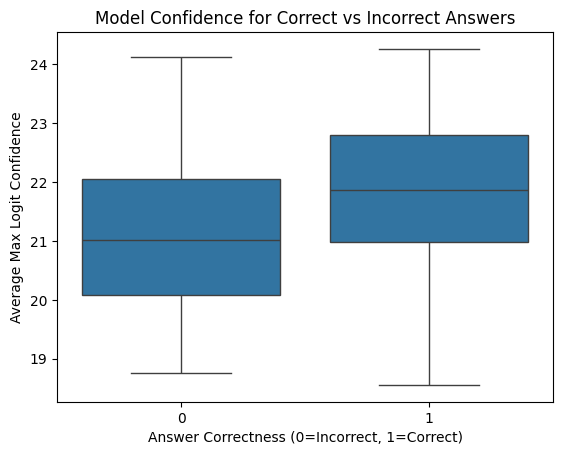

In [27]:
df = pd.DataFrame({'Confidence': confidences, 'Correct': labels})
sns.boxplot(x='Correct', y='Confidence', data=df)
plt.title('Model Confidence for Correct vs Incorrect Answers')
plt.xlabel('Answer Correctness (0=Incorrect, 1=Correct)')
plt.ylabel('Average Max Logit Confidence')
plt.show()

In [28]:
df.to_csv('model_confidence_data_aiKD.csv', index=False)